## Softmax

In [1]:
import numpy as np

In [2]:
vector = np.array([11231, 999, 123142])

In [3]:
vector = np.array([-10, 10, 24])

In [4]:
def softmax(vec):
    vec -= np.max(vec)
    exp = np.exp(vec)
    return exp / np.sum(exp)

In [5]:
softmax(vector)

array([1.71390701e-15, 8.31528028e-07, 9.99999168e-01])

## Assignment-04 基于维基百科的词向量构建

在本章，你将使用Gensim和维基百科获得你的第一批词向量，并且感受词向量的基本过程。

有参考同学作业：supermenfang、bryce、wdmwdm2008

![](https://www.kaggleusercontent.com/kf/1018109/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..JNNggcCCDcYEypvp7ZDwOA.cM9CuDpuCKo0K_ZkMFLAUvhfip0P6SRZ4LddwgTtgwz8pQy1dZeGVJWi6u81KSpAFNSi7YximVVJbPw8xsFySdWlqoUwvSER-LLIRfmlpsCvtDt90NaLYT2FHlwl0tfF-1MKtiFsWlGQ8LGo40hL3ccBSwMZy214kGJf9bNkW_g.kZbF5sgN5qha3zhjilfSDg/__results___files/__results___9_0.png)

In [1]:
import jieba
import gensim

from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import PathLineSentences
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import random
import os
import sys
import codecs
import jieba
import math
import pickle
from hanziconv import HanziConv

import re
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# %matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
from functools import wraps
from collections import defaultdict
from collections import Counter
from functools import lru_cache

In [2]:
file_path = "/Users/lingrowzhang/Documents/Artificial-Intelligence-for-NLP/Artificial-Intelligence-for-NLP/"

## Step-01: Download Wikipedia Chinese Corpus: https://dumps.wikimedia.org/zhwiki/20190720/

第一步：使用维基百科下载中文语料库

终端：$ python3 WikiExtractor.py zhwiki-20190720-pages-articles-multistream.xml.bz2    
-b 10M  切分的文件大小    
-o filename   文件名字

## Step-02: Using https://github.com/attardi/wikiextractor to extract the wikipedia corpus

第二步：使用python wikipedia extractor抽取维基百科的内容

In [3]:
def tradition2simple(line):
    # 将繁体转换成简体
    line = HanziConv.toSimplified(line)
    return line
def cut(string):
    return list(jieba.cut(string))

In [4]:
# 读入停用词表
stop_path = file_path + r"data/symbols_char.csv"
data = pd.read_csv(stop_path, encoding="utf-8")
stop_symbols = []
for tmp in list(data["符号"]):
    for the_char in str(tmp):
        if str(the_char) not in stop_symbols:
            stop_symbols.append(the_char)

In [5]:
stop_word = []
stop_path_2 = file_path + r"data/adv.csv"
data_adv = pd.read_csv(stop_path_2, encoding="utf-8")
stop_word += list(data_adv["WORD"])

In [26]:
# 有加其他停用词，但是停用词的数量和分词获取到的词汇数量，
# 以及觉得词汇始终有一定含义，缩减的信息和可能视为噪音的信息，都本是信息
# 个人选择不停用，虽然知道这对服务器不好

In [27]:
stop_word_try = stop_word + stop_symbols 
# + stop_other 
len(stop_word_try)

1910

In [29]:
stop_word_try = list(set(stop_word_try))
print(len(stop_word_try))
tmp_data = pd.DataFrame(data = stop_word_try)
tmp_data.to_csv(file_path + "data/stop_word.csv")

1901


In [32]:
def get_word(string):
    the_str  = ""
    tmp = 0
    for the_chat in string:
        if ('\u4e00' <= the_chat <= '\u9fa5'):
            the_str += the_chat
            tmp = 0
        elif the_chat == " " and tmp == 0:
            the_str += the_chat
            tmp += 1
    return the_str

In [9]:
all_word = defaultdict(int)
def del_stop_word(string):
    the_string = ""
    for the_word in string.split(" "):
        if the_word in stop_word_try or the_word == "":
            continue
        else:
            all_word[the_word] += 1
            the_string += the_word + " "
    return the_string

In [10]:
# 繁体转换成简体测速
line_tmp = "莫瑞·史丹（Murray Stein，1943 年 9 月 2 日-），出生於加拿大約克頓。取得耶魯大學神學碩士學位，芝加哥大學宗教與心理學博士學位。後於瑞士榮格學院完成榮格分析師訓練。"
line_simple = tradition2simple(line_tmp.strip('\n'))
line_simple = ' '.join(cut(line_simple))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/04/ww1l0rx91jjf64l2y45_44d80000gn/T/jieba.cache
Loading model cost 0.533 seconds.
Prefix dict has been built succesfully.


啥？T^T  肯定是踩的坑不够，或体系是什么？

In [11]:
%%timeit
get_word(line_simple)

15.9 µs ± 505 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
print(get_word(line_simple))

莫瑞 史丹 年 月 日 出 生于 加拿大 约克 顿 取得 耶鲁大学 神学 硕士学位 芝加哥大学 宗教 与 心理学 博士学位 后于 瑞士 荣格 学院 完成 荣格 分析师 训练 


In [13]:
%%timeit
del_stop_word(line_simple)

800 µs ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
print(del_stop_word(line_simple))

莫瑞 史丹 Murray Stein 1943 年 月 日 出 生于 加拿大 约克 顿 取得 耶鲁大学 神学 硕士学位 芝加哥大学 宗教 与 心理学 博士学位 后于 瑞士 荣格 学院 完成 荣格 分析师 训练 


需要对数据进行去除符号和一些无用词，保留有用的词

    
1、符号有助于更加准确切词，所以切词前保留。


## 试验：取数据用startswith，还是re判断

数据中，<doc 所在行是重复的完全去除没影响

In [39]:
# 对数据的处理
tmp_1 = ['<doc id="6647494" url="https://zh.wikipedia.org/wiki?curid=6647494" title="黃花園嘉陵江大橋">','</doc>','吳金淼()，台灣客家人，出生於桃園楊梅，為台灣攝影家，1994年被譽為「楊梅攝影之父」。']

In [40]:
special_list = ['<doc (.*)>', '</doc>']
tmp_4 = []
for tmp in tmp_1:
    for eachone in special_list:
        p = re.compile(eachone)
        tmp_4.append(p.sub('', tmp))
tmp_4
# 结果中数据没有判空导致重复

['',
 '<doc id="6647494" url="https://zh.wikipedia.org/wiki?curid=6647494" title="黃花園嘉陵江大橋">',
 '</doc>',
 '',
 '吳金淼()，台灣客家人，出生於桃園楊梅，為台灣攝影家，1994年被譽為「楊梅攝影之父」。',
 '吳金淼()，台灣客家人，出生於桃園楊梅，為台灣攝影家，1994年被譽為「楊梅攝影之父」。']

In [41]:
def re_tmp():
    for i in range(100):
        tmp_4 = []
        for tmp in tmp_1:
            re_filter = re.findall('<doc id=.*>|</doc>', tmp)
            if not re_filter:
                tmp_4.append(tmp)
    return tmp_4

In [42]:
%%timeit
re_tmp()

194 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
re_tmp()

['吳金淼()，台灣客家人，出生於桃園楊梅，為台灣攝影家，1994年被譽為「楊梅攝影之父」。']

In [44]:
def startswith_tmp():
    for i in range(100):
        tmp_4 = []
        for tmp in tmp_1:
            if not tmp.startswith("<doc") and not tmp.startswith("</doc>"):
                tmp_4.append(tmp)
    return tmp_4


In [45]:
%%timeit
startswith_tmp()

67.7 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
startswith_tmp()

['吳金淼()，台灣客家人，出生於桃園楊梅，為台灣攝影家，1994年被譽為「楊梅攝影之父」。']

## 数据是readlines(200M),还是readline()

In [33]:
def try_readline(file_index):
    with open(file_path + 'AA/wiki_' + file_index, 'r', encoding='UTF-8') as f, \
            open(file_path + "date/wiki/deal_wiki_" + file_index + '.txt', 'w', encoding='UTF-8') as s, \
            open(file_path + "date/wiki/jieba_" + file_index + '.txt', 'w', encoding='UTF-8') as c:
        line = f.readline()
        while line:
            if not line.startswith("<doc") and not line.startswith("</doc>") and not len(line.strip()) == 0:
                line_simple = tradition2simple(line.strip('\n'))
                s.write(line_simple + '\n')
                tempStrs = ' '.join(cut(line_simple))
                get_word_str = get_word(tempStrs)
#                 del_stop_word_str = del_stop_word(get_word_str)
                c.write(get_word_str + '\n')
            line = f.readline()
    return True

In [40]:
%time try_readline()

CPU times: user 4.77 s, sys: 21.3 ms, total: 4.79 s
Wall time: 4.81 s


True

In [41]:
%time try_readline()

CPU times: user 4.64 s, sys: 17.2 ms, total: 4.66 s
Wall time: 4.67 s


True

In [34]:
def try_readlines(file_index):
    with open(file_path + 'AA/wiki_' + file_index, 'r', encoding='UTF-8') as f, \
            open(file_path + "data/wiki/deal_wiki_" + file_index + '.txt', 'w', encoding='UTF-8') as s, \
            open(file_path + "data/wiki/jieba_" + file_index + '.txt', 'w', encoding='UTF-8') as c:
        lines = [''.join(line) for line in f.readlines(1024 * 1024 * 200) if
                 not line.startswith("<doc") and not line.startswith("</doc>") and not len(
                     line.strip()) == 0]
        while lines != []:
            for line in lines:
                line_simple = tradition2simple(line.strip('\n'))
                s.write(line_simple + '\n')
                tempStrs = ' '.join(cut(line_simple))
                get_word_str = get_word(tempStrs)
#                 del_stop_word_str = del_stop_word(get_word_str)
                c.write(get_word_str + '\n')
            lines = [''.join(line) for line in f.readlines(1024 * 1024 * 200) if
                     not line.startswith("<doc") and not line.startswith("</doc>") and not len(
                         line.strip()) == 0]
    return True

In [37]:
%time try_readlines("06")

CPU times: user 4.6 s, sys: 14.4 ms, total: 4.62 s
Wall time: 4.62 s


True

In [82]:
# 取了10M的文本数据就有25万词
# 而其中数量大于100的有6033
# 而其中数量大于50的有11137
a = []
b = []
for tmp in all_word:
    number = all_word[tmp]
    if number > 0:
        a.append(tmp)
        b.append(number)
print(len(a))

255601


In [42]:
%%time
file_index = 4
wiki_txt = r"/Users/lingrowzhang/Documents/Artificial-Intelligence-for-NLP/date/test/"

filepath_cut = wiki_txt + 'deal_wiki_'
with open(wiki_txt + 'wiki_0'    + str(file_index), 'r',  encoding='UTF-8') as f, \
    open(wiki_txt + "deal_wiki_" + str(file_index) + '.txt', 'w', encoding='UTF-8') as s, \
    open(filepath_cut + "jieba_" + str(file_index) + '.txt', 'w', encoding='UTF-8') as c:
    line = f.readline()
    while line:
        if not line.startswith("<doc") and not line.startswith("</doc>") and not len(line.strip()) == 0:
            line_simple = tradition2simple(line.strip('\n'))
            s.write(line_simple + '\n')
            tempStrs = ' '.join(cut(line_simple))
            get_word_str = get_word(tempStrs)
            del_stop_word_str = del_stop_word(get_word_str)
            c.write(del_stop_word_str + '\n')
        line = f.readline()

CPU times: user 47.2 s, sys: 176 ms, total: 47.3 s
Wall time: 47.5 s


In [83]:
tmp_data = pd.DataFrame(data = {"word":a,"number":b} )
tmp_data.to_csv("/Users/lingrowzhang/Documents/Artificial-Intelligence-for-NLP/date/test/all_word.csv", encoding="gbk", index=False)

从所有的词汇看出：    
1、数据长尾很长，    
2、词汇在加文本后不断会新增，主要因为分词会逐渐出现组合词，    
3、停用词汇意义不大，我有找网络的停用词也只有2千左右，其中部分高频词汇在我个人看来对于后续可能的处理也有作用，视情况做处理。    
4、有日常特殊功能的词汇会被经常使用，比如：“年月日”、地点、事迹，这可以考虑到数据来源于百科，多以介绍性文本为主。而估计词条的单词，多为一些专有名词的出现。比如：人名、影视作品名。    

    
综上信息，是否有用我不清楚

In [23]:
line_simple

'麦可·柏辛格（Mike Bolsinger，） ，为美国的棒球选手之一，于于2010年美国职棒选秀为亚利桑那响尾蛇选进，曾于2015-2016年二个球季于洛杉矶道奇上过大联盟。2018年球季效力于日本职棒千叶罗德海洋队，守备位置为投手。'

In [24]:
%%timeit
tempStrs = ' '.join(tmp for tmp in cut(line_simple))

354 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
tempStrs

'麦 可 · 柏 辛格 （ Mike   Bolsinger ， ）   ， 为 美国 的 棒球 选手 之一 ， 于于 2010 年 美国 职棒 选秀 为 亚利桑那 响尾蛇 选进 ， 曾于 2015 - 2016 年 二个 球季 于 洛杉矶 道奇 上过 大 联盟 。 2018 年 球季 效力 于 日本 职棒 千叶 罗德 海洋 队 ， 守备 位置 为 投手 。'

In [26]:
%%timeit
get_word_str = get_word(tempStrs)

21.3 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
get_word_str

'麦 可 柏 辛格 为 美国 的 棒球 选手 之一 于于 年 美国 职棒 选秀 为 亚利桑那 响尾蛇 选进 曾于 年 二个 球季 于 洛杉矶 道奇 上过 大 联盟 年 球季 效力 于 日本 职棒 千叶 罗德 海洋 队 守备 位置 为 投手 '

In [28]:
%%timeit
del_stop_word(get_word_str)

1.76 ms ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
get_word_str

'麦 可 柏 辛格 为 美国 的 棒球 选手 之一 于于 年 美国 职棒 选秀 为 亚利桑那 响尾蛇 选进 曾于 年 二个 球季 于 洛杉矶 道奇 上过 大 联盟 年 球季 效力 于 日本 职棒 千叶 罗德 海洋 队 守备 位置 为 投手 '

T^T  对自己说，抓重点呀！！！

## 主体，上面是测试和优化

In [36]:
def tradition2simple(line):
    # 将繁体转换成简体
    line = HanziConv.toSimplified(line)
    return line
def cut(string):
    return list(jieba.cut(string))

In [38]:
def try_readlines(file_index):
    with open(file_path + 'AA/wiki_' + file_index, 'r', encoding='UTF-8') as f, \
            open(file_path + "data/wiki/deal_wiki_" + file_index + '.txt', 'w', encoding='UTF-8') as s, \
            open(file_path + "data/wiki/jieba_" + file_index + '.txt', 'w', encoding='UTF-8') as c:
        lines = [''.join(line) for line in f.readlines(1024 * 1024 * 200) if
                 not line.startswith("<doc") and not line.startswith("</doc>") and not len(
                     line.strip()) == 0]
        while lines != []:
            for line in lines:
                line_simple = tradition2simple(line.strip('\n'))
                s.write(line_simple + '\n')
                tempStrs = ' '.join(cut(line_simple))
                get_word_str = get_word(tempStrs)
#                 del_stop_word_str = del_stop_word(get_word_str)
                c.write(get_word_str + '\n')
            lines = [''.join(line) for line in f.readlines(1024 * 1024 * 200) if
                     not line.startswith("<doc") and not line.startswith("</doc>") and not len(
                         line.strip()) == 0]
    return True
for path,_,files in os.walk(file_path + "AA/"):
    for the_file in files:
        if "wiki" in str(the_file):
            try_readlines(the_file[len(the_file)-2:])
            print(the_file)
print("切分为50M的wiki数据处理完成")

wiki_11
wiki_16
wiki_20
wiki_18
wiki_19
wiki_21
wiki_17
wiki_10
wiki_03
wiki_04
wiki_05
wiki_02
wiki_15
wiki_12
wiki_24
wiki_23
wiki_22
wiki_25
wiki_13
wiki_14
wiki_09
wiki_07
wiki_00
wiki_01
wiki_06
wiki_08


## Step-03: Using gensim get word vectors: 

Reference: 

+ https://radimrehurek.com/gensim/models/word2vec.html
+ https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第三步：参考Gensim的文档和Kaggle的参考文档，获得词向量。 注意，你要使用Jieba分词把维基百科的内容切分成一个一个单词，然后存进新的文件中。然后，你需要用Gensim的LineSentence这个类进行文件的读取。

在训练成词向量Model.

text: 分词处理之后的语料，词汇空格连接    
size: 词向量维度（词汇向量用多少数值表示），默认值是100    
min_count: 需要计算词向量的最小词频。默认5，过滤后面大量的长尾词    
window: 滑动窗口大小，默认5？？    
sg: 默认0，CBOW模型；1，Skip-Gram    

In [51]:
i=0
for path,_,files in os.walk(file_path + "AA/"):
    for the_file in files:
        if "wiki" in str(the_file):
            wiki_news = open(file_path + 'data/wiki/jieba_' + the_file[len(the_file)-2:] + '.txt', 'r', encoding='utf-8')
            sentences = LineSentence(wiki_news)
            if i == 0:
                i+=1
                model = Word2Vec(sentences, size=100, min_count=5, window=5, workers=8)
                model.save('word2vec'+ the_file[len(the_file)-2:] +'.model')
            else:
                model.build_vocab(sentences, update=True)  # 更新词汇表
                model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)  # epoch=iter语料库的迭代次数；（默认为5）  total_examples:句子数。
            print(the_file)

wiki_11


/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


wiki_16
wiki_20
wiki_18
wiki_19
wiki_21
wiki_17
wiki_10
wiki_03
wiki_04
wiki_05
wiki_02
wiki_15
wiki_12
wiki_24
wiki_23
wiki_22
wiki_25
wiki_13
wiki_14
wiki_09
wiki_07
wiki_00
wiki_01
wiki_06
wiki_08


In [52]:
model.save('word2vec.model')

## Step-04: Using some words to test your preformance. 

第四步，测试同义词，找几个单词。

In [ ]:
model.save('word2vec.model')
# 导入模型预测
# 方法一
model = Word2Vec.load('word2vec.model')

In [86]:
model.wv.similarity("棒球", "海洋")

0.7927233

In [53]:
model.wv.similarity("棒球", "海洋")

0.055939905

In [87]:
model.wv.distance("危险", "声音")

0.009278178215026855

In [54]:
model.wv.distance("危险", "声音")

0.8338703215122223

In [62]:
model.wv.most_similar("危险")

[('可怕', 0.6525280475616455),
 ('脆弱', 0.6444193720817566),
 ('严重', 0.6211889982223511),
 ('困难', 0.6058051586151123),
 ('恶劣', 0.5982829332351685),
 ('危急', 0.5909044742584229),
 ('头疼', 0.590834379196167),
 ('致命', 0.5823118686676025),
 ('反常', 0.5790187120437622),
 ('急迫', 0.577808141708374)]

In [63]:
model.wv.most_similar("声音")

[('声响', 0.7393018007278442),
 ('刺耳', 0.7028720378875732),
 ('哨声', 0.6940298080444336),
 ('歌声', 0.6893526911735535),
 ('沙哑', 0.6793839931488037),
 ('笑声', 0.6735013723373413),
 ('音量', 0.6597989201545715),
 ('音调', 0.6523874402046204),
 ('叫声', 0.651728630065918),
 ('低沉', 0.6459029316902161)]

In [55]:
model.wv.most_similar("海洋")

[('海洋生物', 0.6987504959106445),
 ('水圈', 0.6827729940414429),
 ('水循环', 0.6816586256027222),
 ('生态系统', 0.6687697768211365),
 ('海底', 0.6680244207382202),
 ('海洋环境', 0.6588195562362671),
 ('深海', 0.6478520631790161),
 ('北极', 0.6447347402572632),
 ('水体', 0.6406235098838806),
 ('上升流', 0.6376502513885498)]

## Step-05: Using visualization tools: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第五步：使用Kaggle给出的T-SEN进行词向量的可视化。

/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


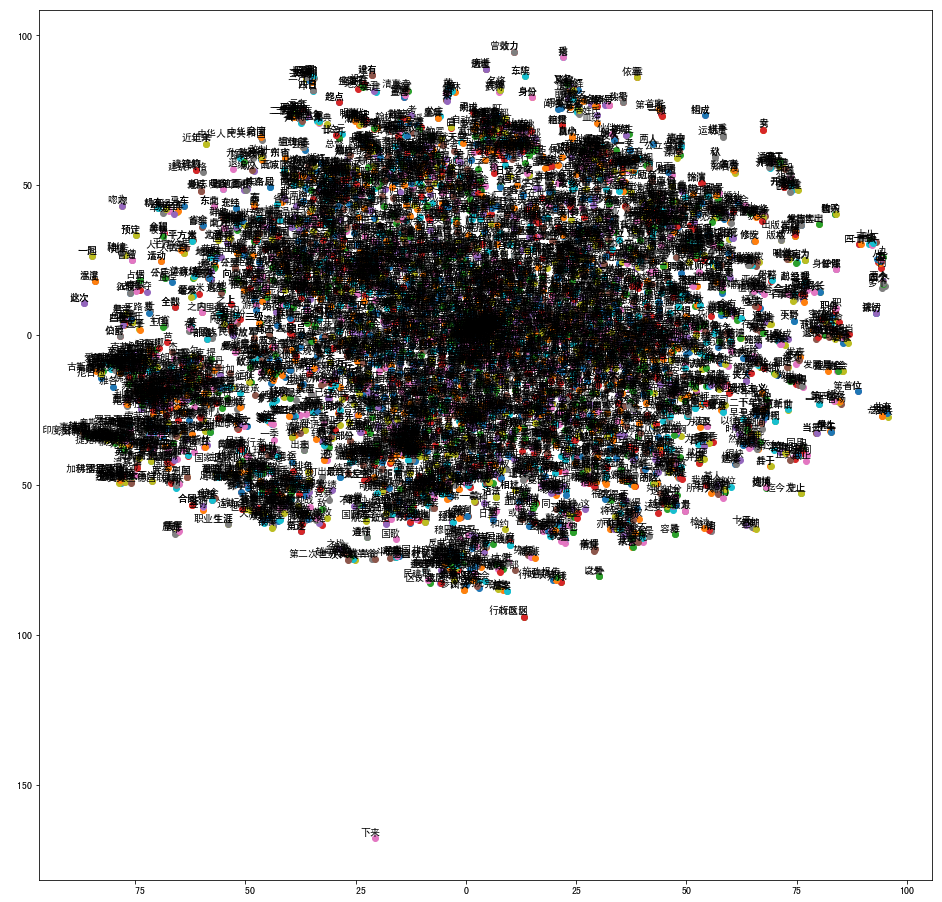

In [56]:
labels = []
tokens = []
index = 0
for word in model.wv.vocab:
    index = index + 1
    if index > 5000:
        break
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

此时的数据只有大量文本之间的规律，没有任何实际的意义。而且数据每次运算得出的效果都有所不同。

/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


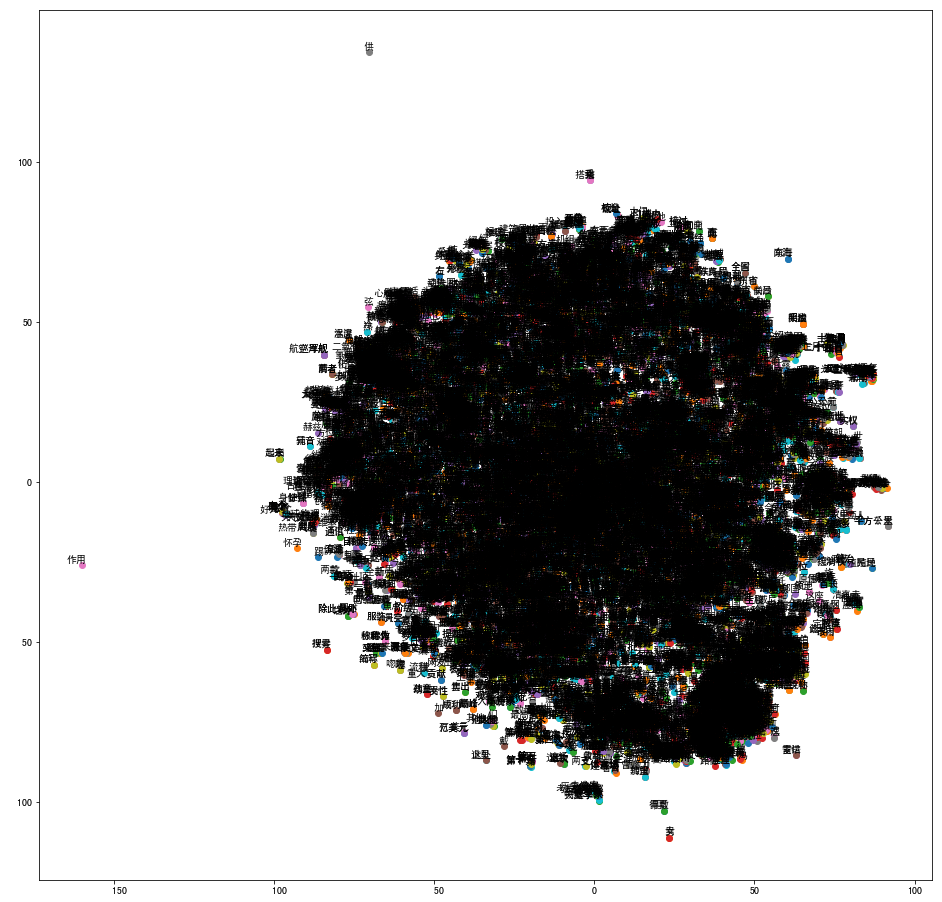

In [61]:
labels = []
tokens = []
index = 0
for word in model.wv.vocab:
    index = index + 1
    if index > 12000:
        break
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [94]:
# 模型导出保存
model.save('word2vec.model')
# 导入模型预测
# 方法一
model = Word2Vec.load('word2vec.model')
# # 方法二
# with open('/home/aistudio/data/data10325/corpus.pickle', 'rb') as f:
#     corpus = pickle.load(f)
# corpus[-1] 
# model = Word2Vec(sentences=corpus, size=300, window=5, min_count=3, workers=4)

In [57]:
model.wv.most_similar("理解")

[('解释', 0.7629767656326294),
 ('解读', 0.7487218976020813),
 ('表述', 0.7164461612701416),
 ('认知', 0.7067645192146301),
 ('概括', 0.7017437219619751),
 ('表达', 0.7006967067718506),
 ('诠释', 0.7001879811286926),
 ('想像', 0.6949183940887451),
 ('了解', 0.683027982711792),
 ('阐释', 0.6775388121604919)]

In [58]:
model.wv.most_similar("对话")

[('交谈', 0.7795593738555908),
 ('对谈', 0.7593792676925659),
 ('谈话', 0.7310072779655457),
 ('互动', 0.7209185361862183),
 ('沟通', 0.709114670753479),
 ('会谈', 0.6491734385490417),
 ('聊天', 0.6427433490753174),
 ('通话', 0.6327193379402161),
 ('会面', 0.6285299062728882),
 ('直接对话', 0.6178647875785828)]

In [59]:
model.wv.most_similar("沟通")

[('互动', 0.733817458152771),
 ('交流', 0.712864100933075),
 ('对话', 0.709114670753479),
 ('交谈', 0.6769622564315796),
 ('沟通交流', 0.6536829471588135),
 ('相互了解', 0.6318866014480591),
 ('协调', 0.6269423961639404),
 ('相互理解', 0.6266570091247559),
 ('直接对话', 0.6145931482315063),
 ('通话', 0.6060094833374023)]

/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


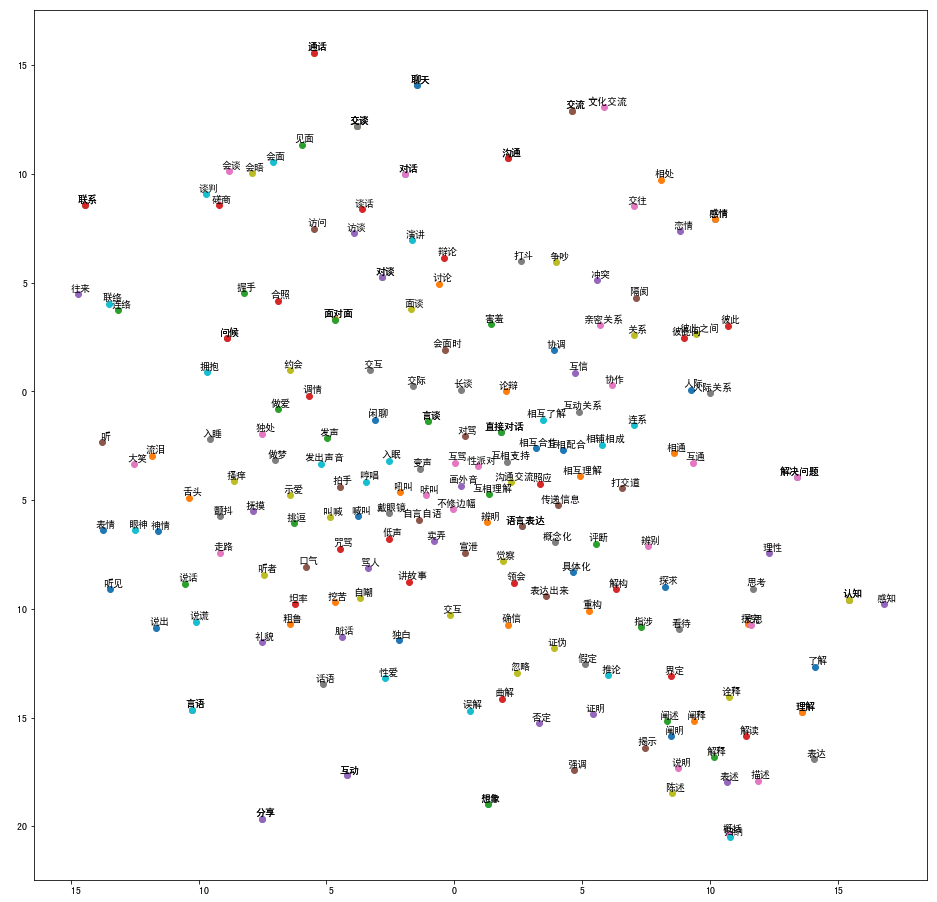

In [60]:
# 找相似的词画图
def tsne_plot(model):
    labels = []
    tokens = []
    
    words = ['对话','理解','说话','沟通']
    for word in words:
        labels.append(word)
        tokens.append(model[word])
        for sim, _ in model.wv.most_similar(word, topn=50):
            labels.append(sim)
            tokens.append(model[sim])
        
    tsne = TSNE(perplexity=40, init='pca', n_iter=3500, random_state=42)
    new_vectors = tsne.fit_transform(tokens)
    
    x, y = [], []
    for v1, v2 in new_vectors:
        x.append(v1)
        y.append(v2)
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(3, 2), textcoords='offset points', ha='center', va='bottom')
        
    plt.show()
tsne_plot(model)

/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/lingrowzhang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


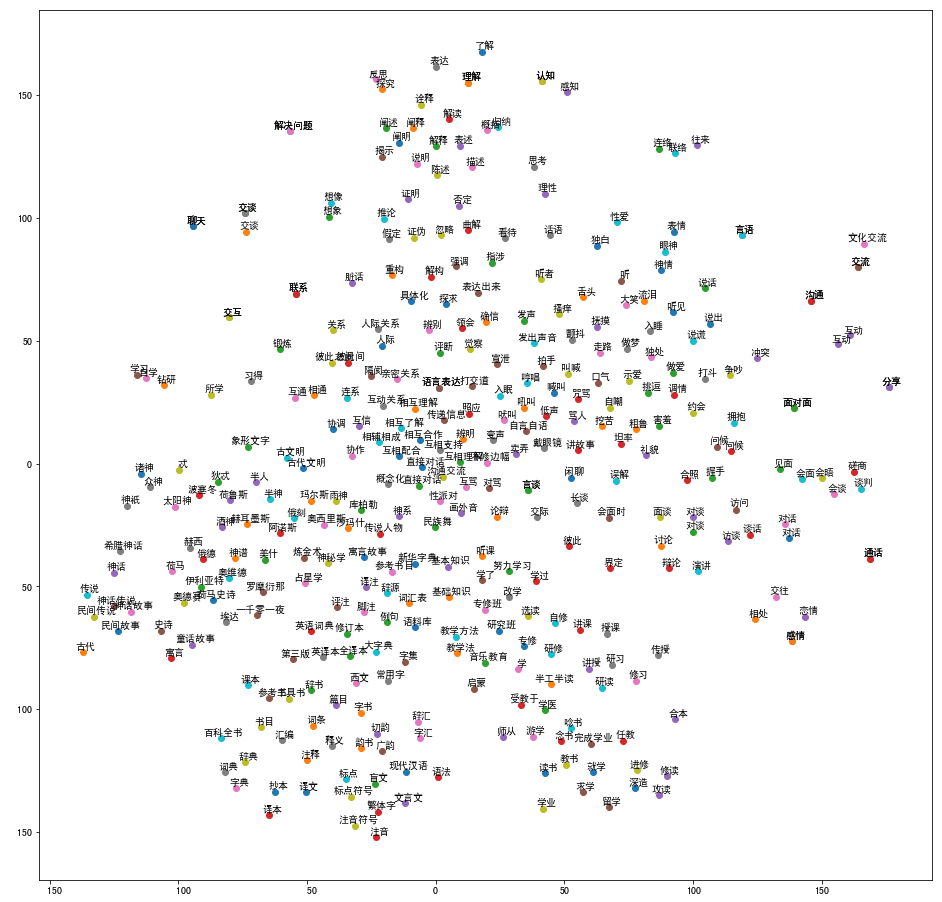

In [66]:
# 找相似的词画图
def tsne_plot(model):
    labels = []
    tokens = []
    
    words = ['对话','理解','说话','沟通','神话','学习','字典']
    for word in words:
        labels.append(word)
        tokens.append(model[word])
        for sim, _ in model.wv.most_similar(word, topn=50):
            labels.append(sim)
            tokens.append(model[sim])
        
    tsne = TSNE(perplexity=40, init='pca', n_iter=3500, random_state=42)
    new_vectors = tsne.fit_transform(tokens)
    
    x, y = [], []
    for v1, v2 in new_vectors:
        x.append(v1)
        y.append(v2)
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(3, 2), textcoords='offset points', ha='center', va='bottom')
        
    plt.show()
tsne_plot(model)